<a href="https://colab.research.google.com/github/josepedroso/segmented_dicom_images/blob/main/teste_arrumando_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pydicom

In [3]:
pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [4]:
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import pydicom as dicom
import os
from IPython.display import clear_output

In [5]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

def normalize(input_image, input_mask):
  input_image = tf.image.resize(input_image, (512, 512), method="nearest")
  input_mask = tf.image.resize(input_mask, (512, 512), method="nearest")
  #input_image, input_mask = augment(input_image, input_mask)
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32) / 255.0
  return input_image, input_mask

def normalize_canais(input_image):
    input_image = np.stack((input_image,)*3, axis=-1)
    return input_image

def normalize_canais_mask(input_image):
    input_image = np.stack((input_image,)*1, axis=-1)
    return input_image

In [6]:

def print_shape(train):
  for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
  print(sample_image.shape, sample_mask.shape)

def sort_list(list_str):
  x=[]
  dig="0123456789"
  for i in list_str:
      p=""
      for j in i:
          if j in dig:
              p+=j
      x.append(int(p))
  y=[]
  y.extend(x)
  x.sort()
  res=[]
  for i in x:
      res.append(list_str[y.index(i)])
  return res

def create_dataset(images, masks, batch_size):
    # Cria um dataset com as imagens e masks
    data_base = tf.data.Dataset.from_tensor_slices((images, masks))

    # Aplica o pré-processamento nas imagens
    data_base = data_base.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = data_base.shuffle(1000).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return data_base, dataset

In [7]:
path_train = "/content/drive/MyDrive/scans/train"
path_teste = "/content/drive/MyDrive/scans/test"
path_val = "/content/drive/MyDrive/scans/validation"

segmentation = []
imagens = []
seg_aux_paths = []
paths_seg = []
paths_img = []

def get_images_dir(path):
  for root, dirs, files in os.walk(path):
    files.sort()
    for file in files:
      relativePath = os.path.join(root, file)
      if('lung_mask' in relativePath):
        seg_aux_paths.append(relativePath)
      else:
        paths_img.append(relativePath)

    if('lung_mask' in root):
      aux_name = sort_list(seg_aux_paths)
      seg_aux_paths.clear()
      for filepath in aux_name:
        paths_seg.append(filepath)

def get_images(path, batch_size_dataset):
      get_images_dir(path)
      print(len(paths_seg), len(paths_img))
      for i in range(len(paths_seg)):
        path_image, path_mask = paths_seg[i], paths_img[i]
        segmentation.append(normalize_canais_mask(dicom.dcmread(path_image).pixel_array))
        imagens.append(normalize_canais(dicom.dcmread(path_mask).pixel_array))

      data, dataset = create_dataset(imagens, segmentation, batch_size=batch_size_dataset)
      segmentation.clear()
      imagens.clear()
      paths_seg.clear()
      paths_img.clear()
      return data, dataset


In [8]:
train_data, train_dataset = get_images(path_train, 13)
teste_data, teste_dataset = get_images(path_teste, 5)
val_data, val_dataset = get_images(path_val, 5)

130 130
27 27
21 21


In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [10]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[512, 512, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Cria o modelo de extração de características
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [11]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

def unet_model(output_channels):

  # Esta é a última camada do modelo
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[512, 512, 3])
  x = inputs

  # Downsampling através do modelo
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling e estabelecimento das conexões de salto
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

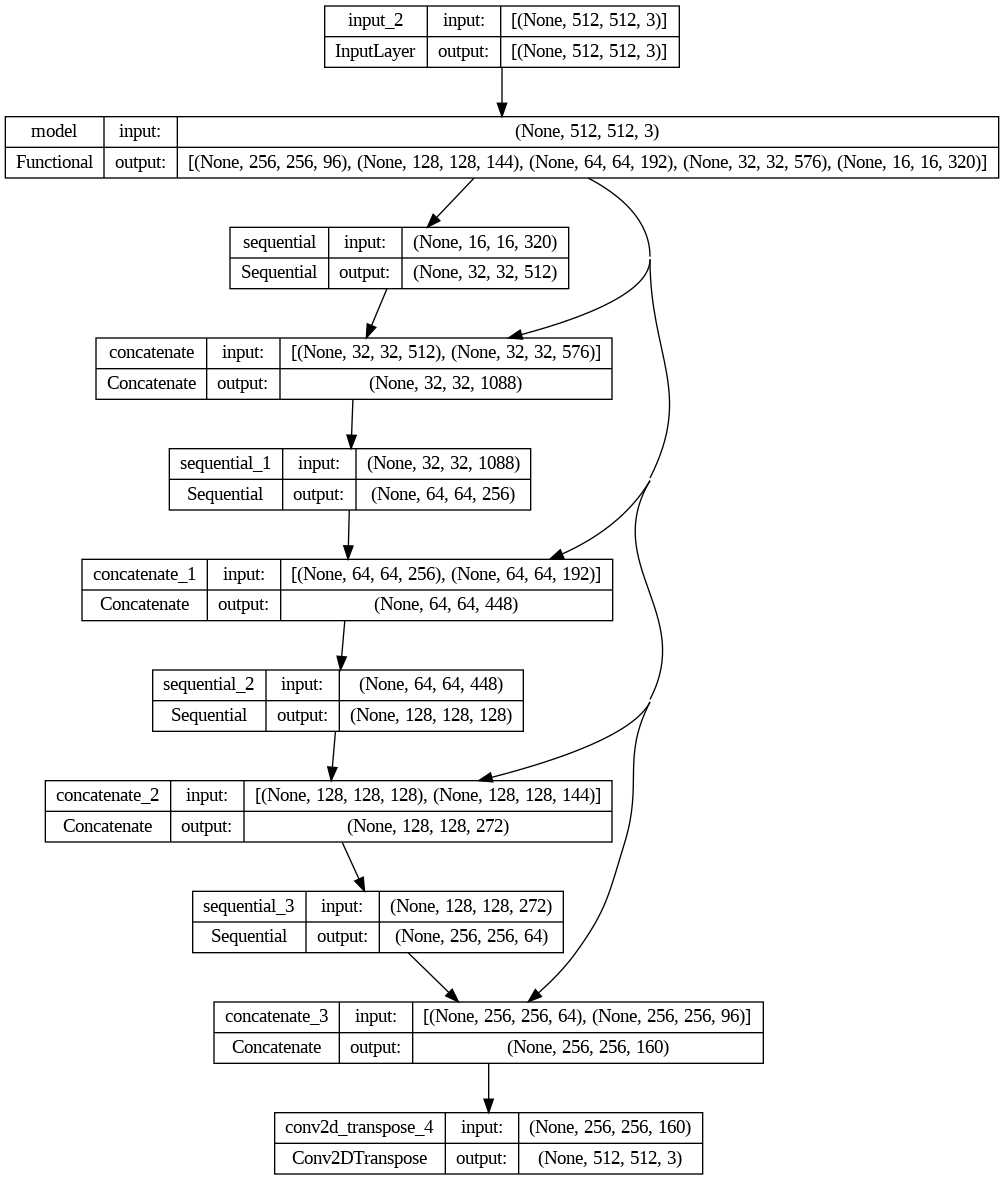

In [12]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

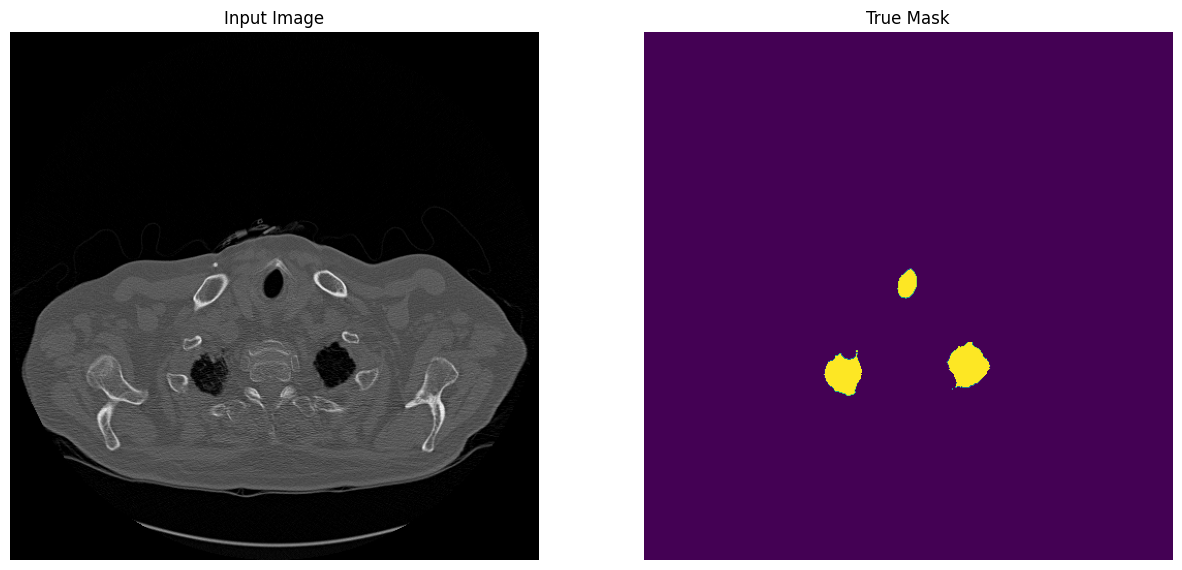

In [13]:
for image, mask in train_data.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

1/1 [==============================] - 3s 3s/step


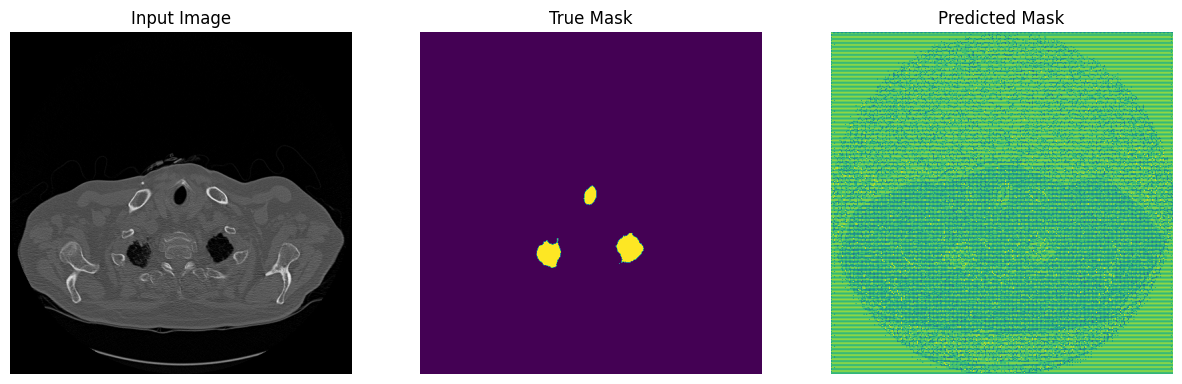

In [14]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 1s 509ms/step


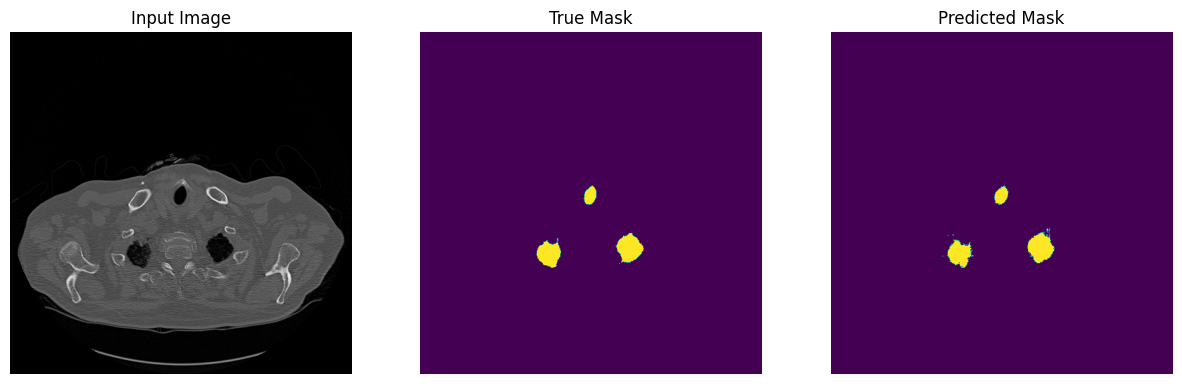


Sample Prediction after epoch 10

10/10 [==============================] - 210s 21s/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.0328 - val_accuracy: 0.9891


In [16]:
epochs = 10

model_history = model.fit(train_dataset,
                              epochs=epochs,
                               callbacks=[DisplayCallback()],
                                          validation_data=val_dataset)

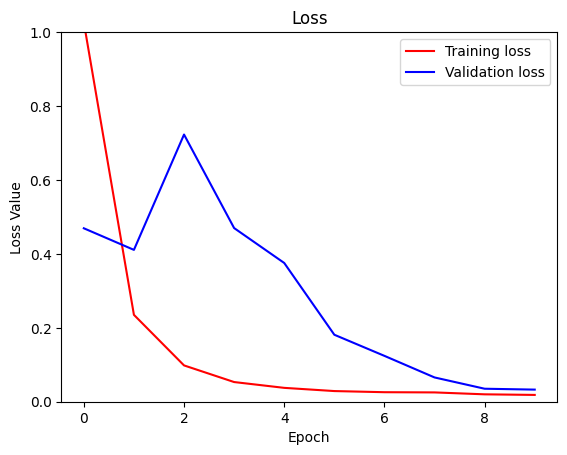

In [17]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(10)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

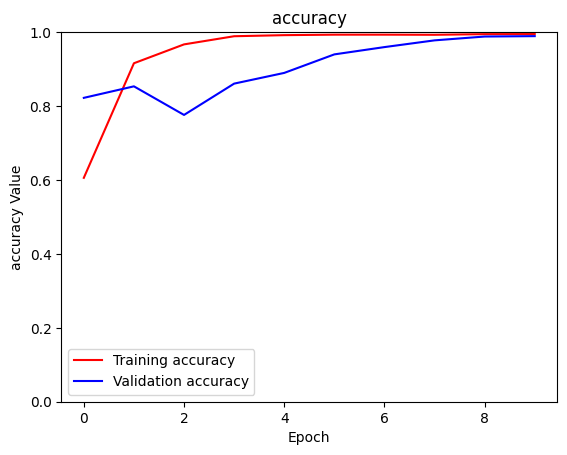

In [18]:
t_accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
epochs = range(10)

plt.figure()
plt.plot(epochs, t_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 4s 4s/step


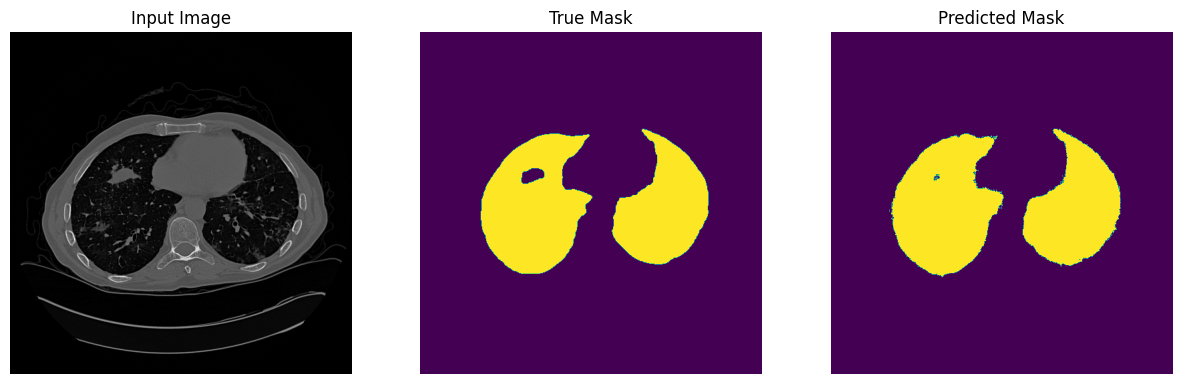

1/1 [==============================] - 3s 3s/step


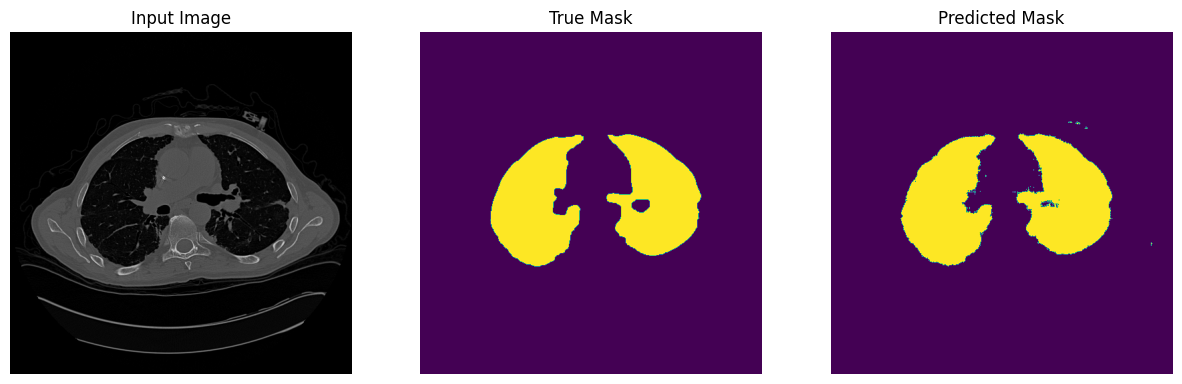

1/1 [==============================] - 3s 3s/step


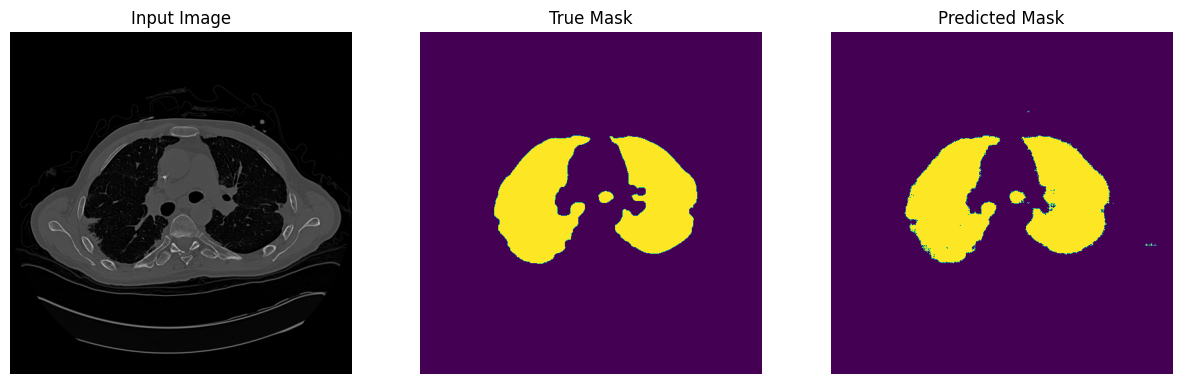

1/1 [==============================] - 3s 3s/step


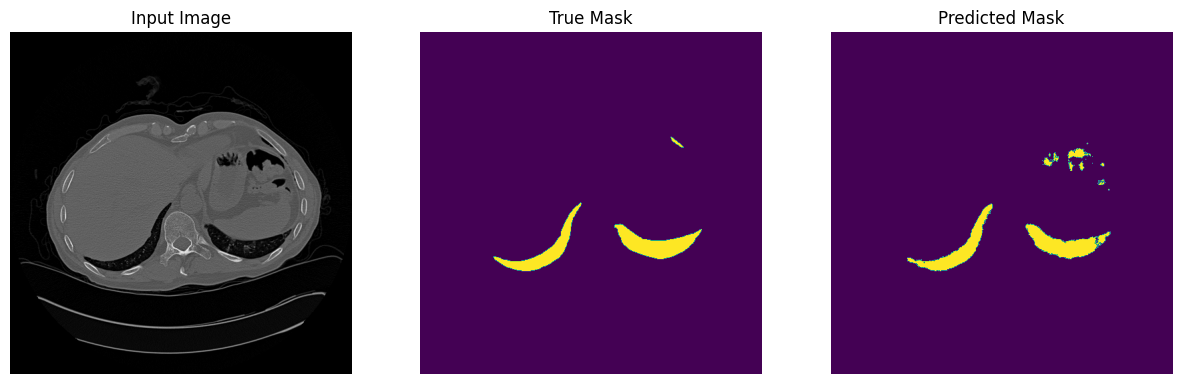

1/1 [==============================] - 3s 3s/step


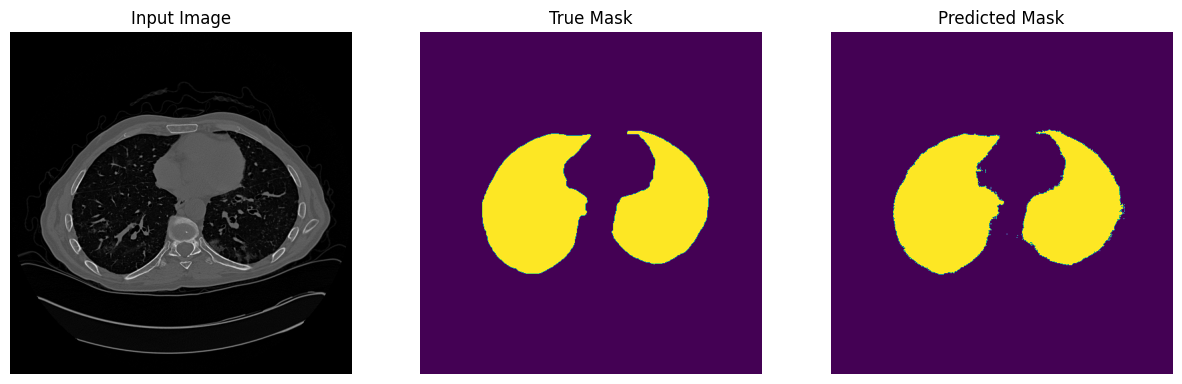

1/1 [==============================] - 1s 1s/step


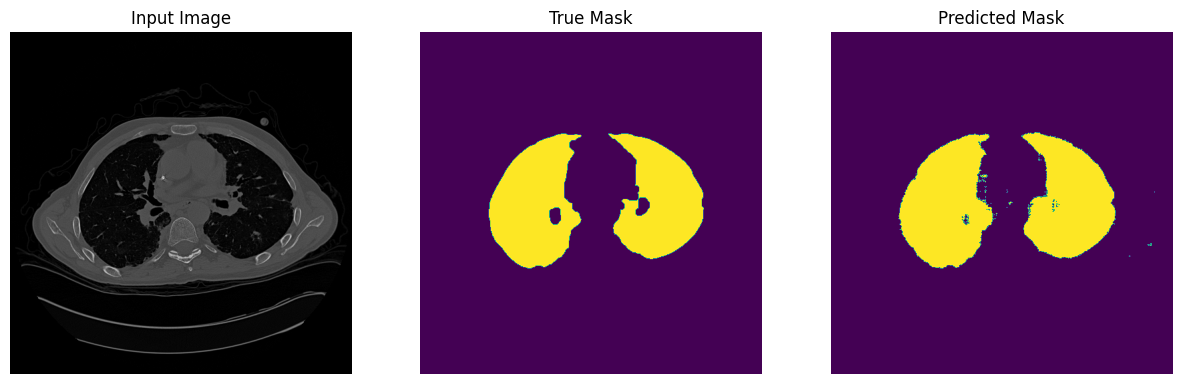

In [19]:
show_predictions(teste_dataset, 10)